In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from astroML.utils import completeness_contamination

import corner

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
file = '../../GW_samples.h5'
data = h5py.File(file, 'r')

In [4]:
list(data.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

In [5]:
#build the arrays
N_train = 10000
N_test = int(0.3 * N_train)

chi1x_test, chi1x_train = data['chi1x'][:N_test], data['chi1x'][N_test:N_train]
chi1y_test, chi1y_train = data['chi1y'][:N_test], data['chi1y'][N_test:N_train]
chi1z_test, chi1z_train = data['chi1z'][:N_test], data['chi1z'][N_test:N_train]

chi2x_test, chi2x_train = data['chi2x'][:N_test], data['chi2x'][N_test:N_train]
chi2y_test, chi2y_train = data['chi2y'][:N_test], data['chi2y'][N_test:N_train]
chi2z_test, chi2z_train = data['chi2z'][:N_test], data['chi2z'][N_test:N_train]

dec_test, dec_train = data['dec'][:N_test], data['dec'][N_test:N_train]
ra_test, ra_train = data['ra'][:N_test], data['ra'][N_test:N_train]
det_test, det_train = data['det'][:N_test], data['det'][N_test:N_train] # 0 or 1
iota_test, iota_train = data['iota'][:N_test], data['iota'][N_test:N_train]
mtot_test, mtot_train = data['mtot'][:N_test], data['mtot'][N_test:N_train]
psi_test, psi_train = data['psi'][:N_test], data['psi'][N_test:N_train]
q_test, q_train = data['q'][:N_test], data['q'][N_test:N_train]
snr_test, snr_train = data['snr'][:N_test], data['snr'][N_test:N_train]
z_test, z_train = data['z'][:N_test], data['z'][N_test:N_train]

In [6]:
data_train = np.column_stack((z_train, mtot_train, q_train, chi1z_train, chi2z_train,  iota_train, psi_train))
data_test = np.column_stack((z_test, mtot_test, q_test, chi1z_test, chi2z_test, iota_test, psi_test))
labels = [r'$z$', r'$M_{tot}$', r'$q$', r'$\chi_{1z}$', r'$\chi_{2z}$', r'$\iota$', r'$\psi$']

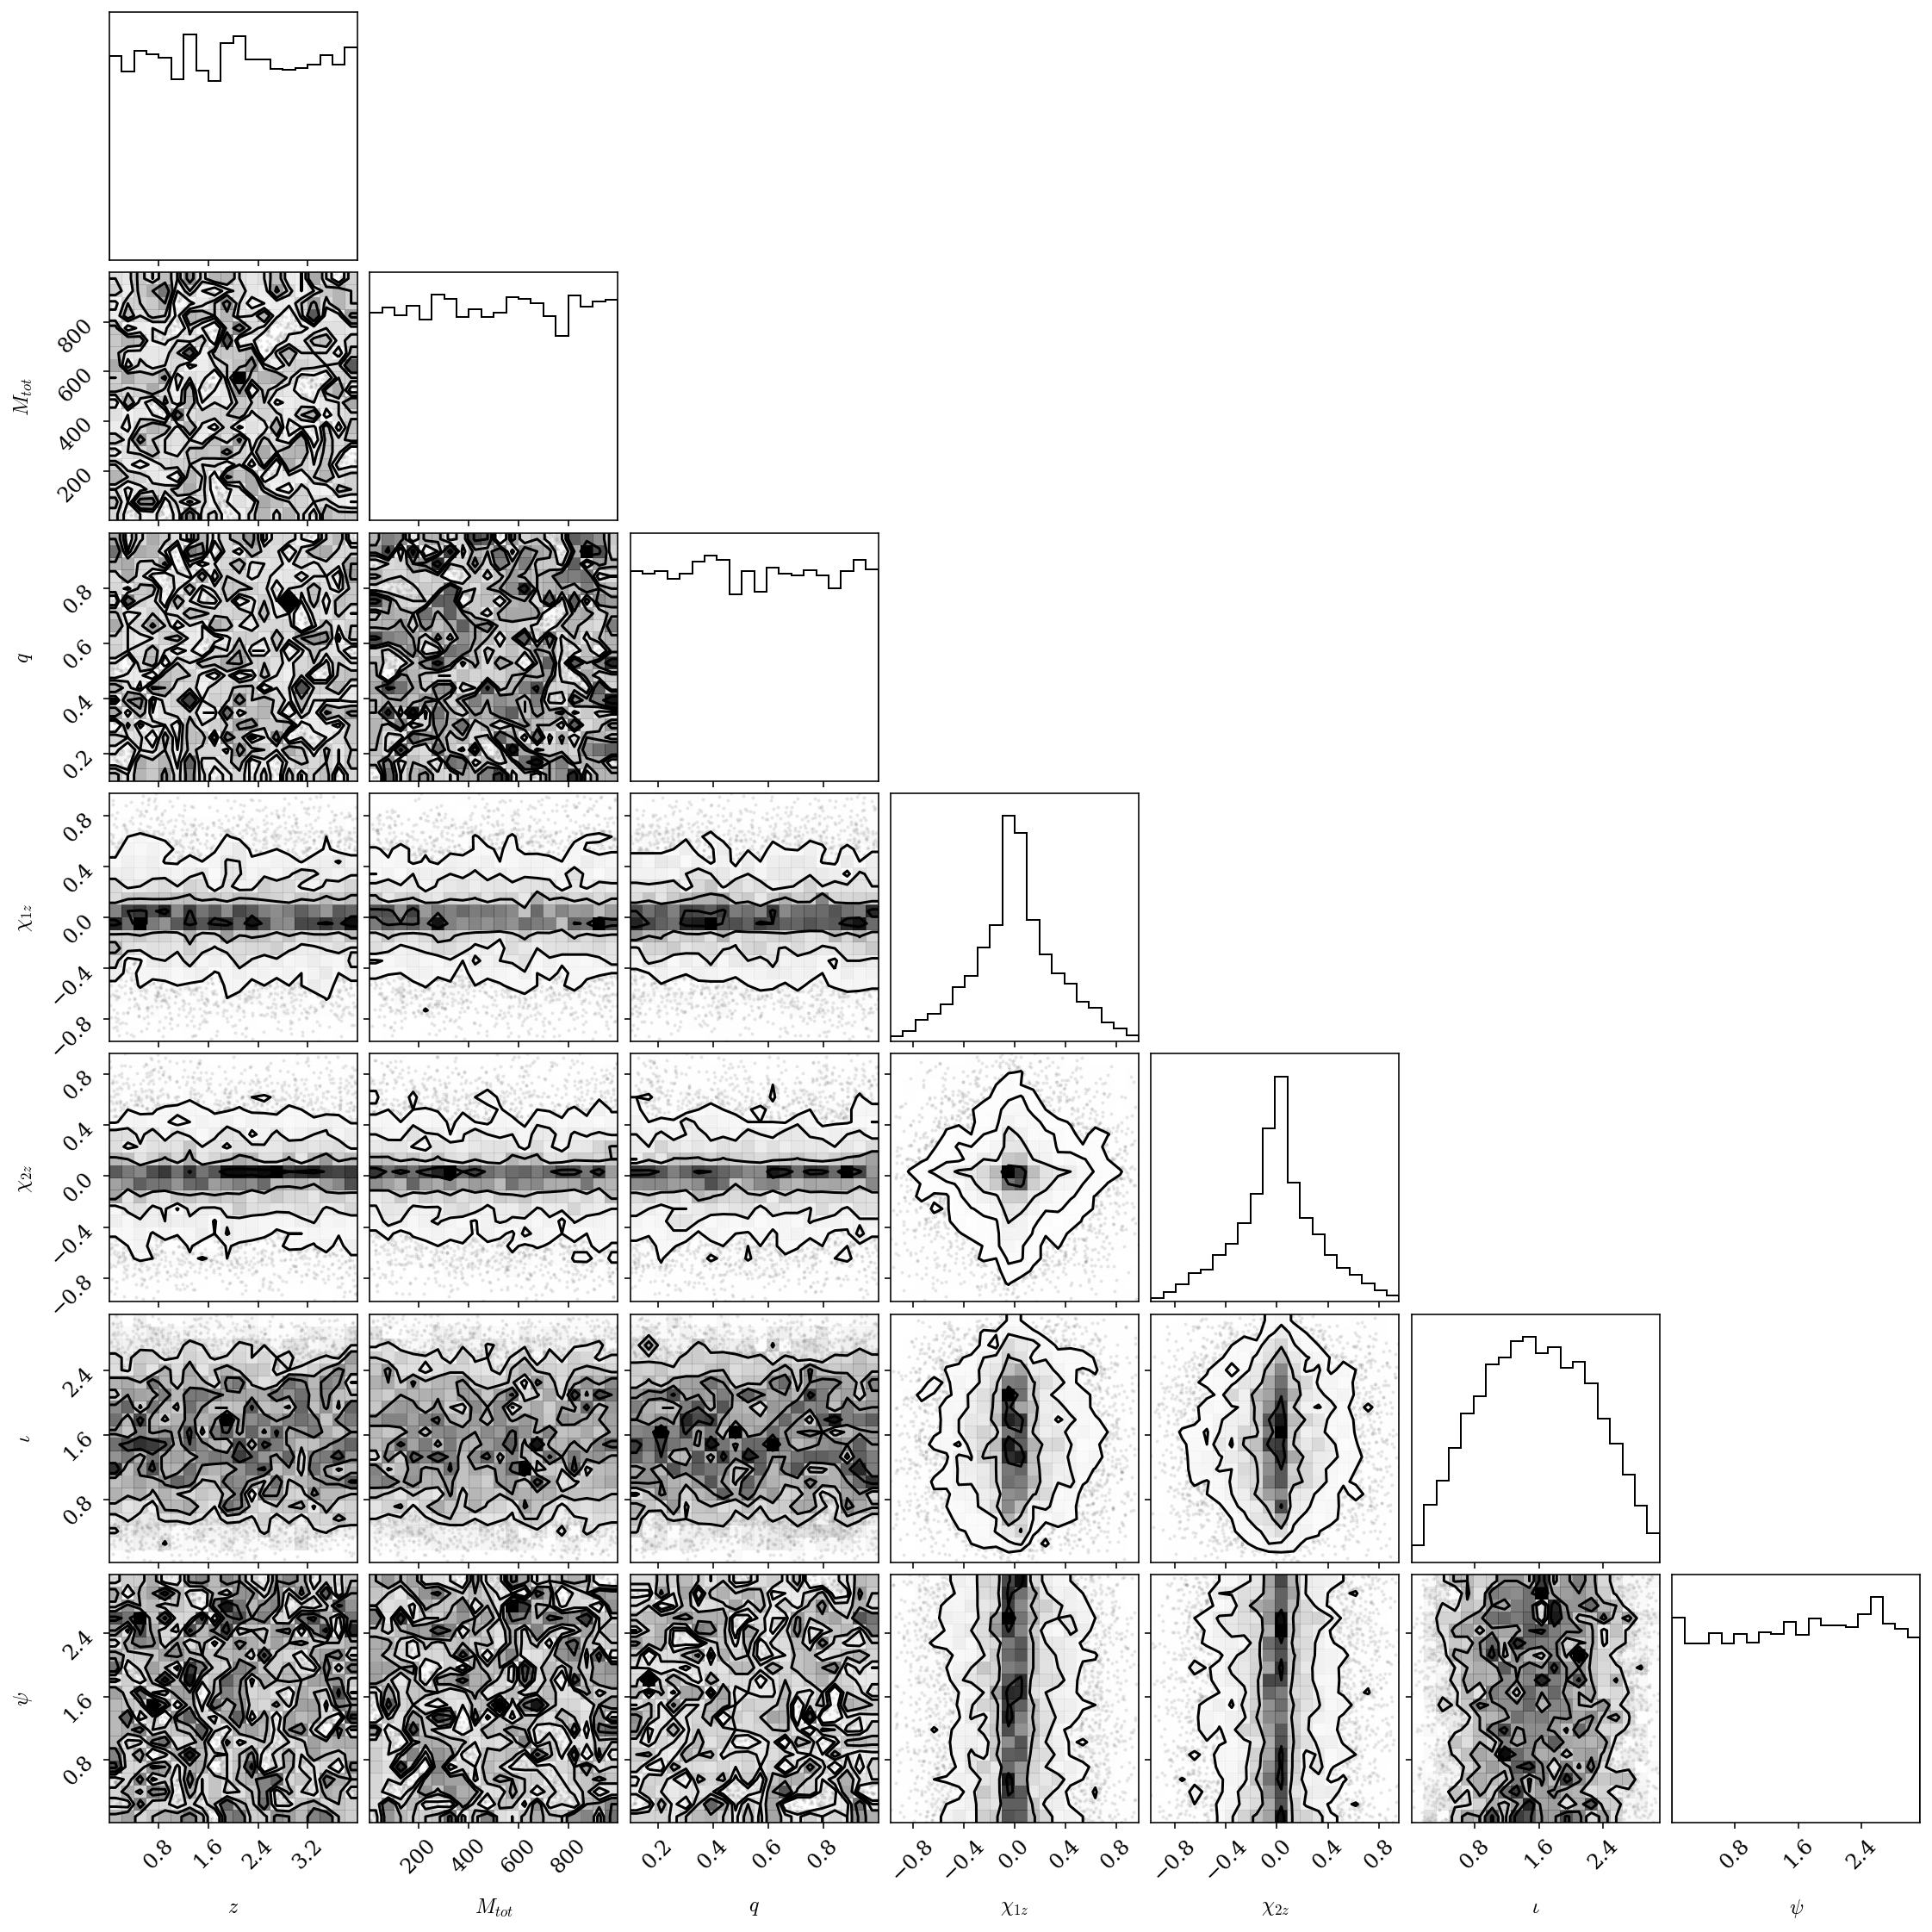

In [7]:
corner.corner(data_train, labels=labels);

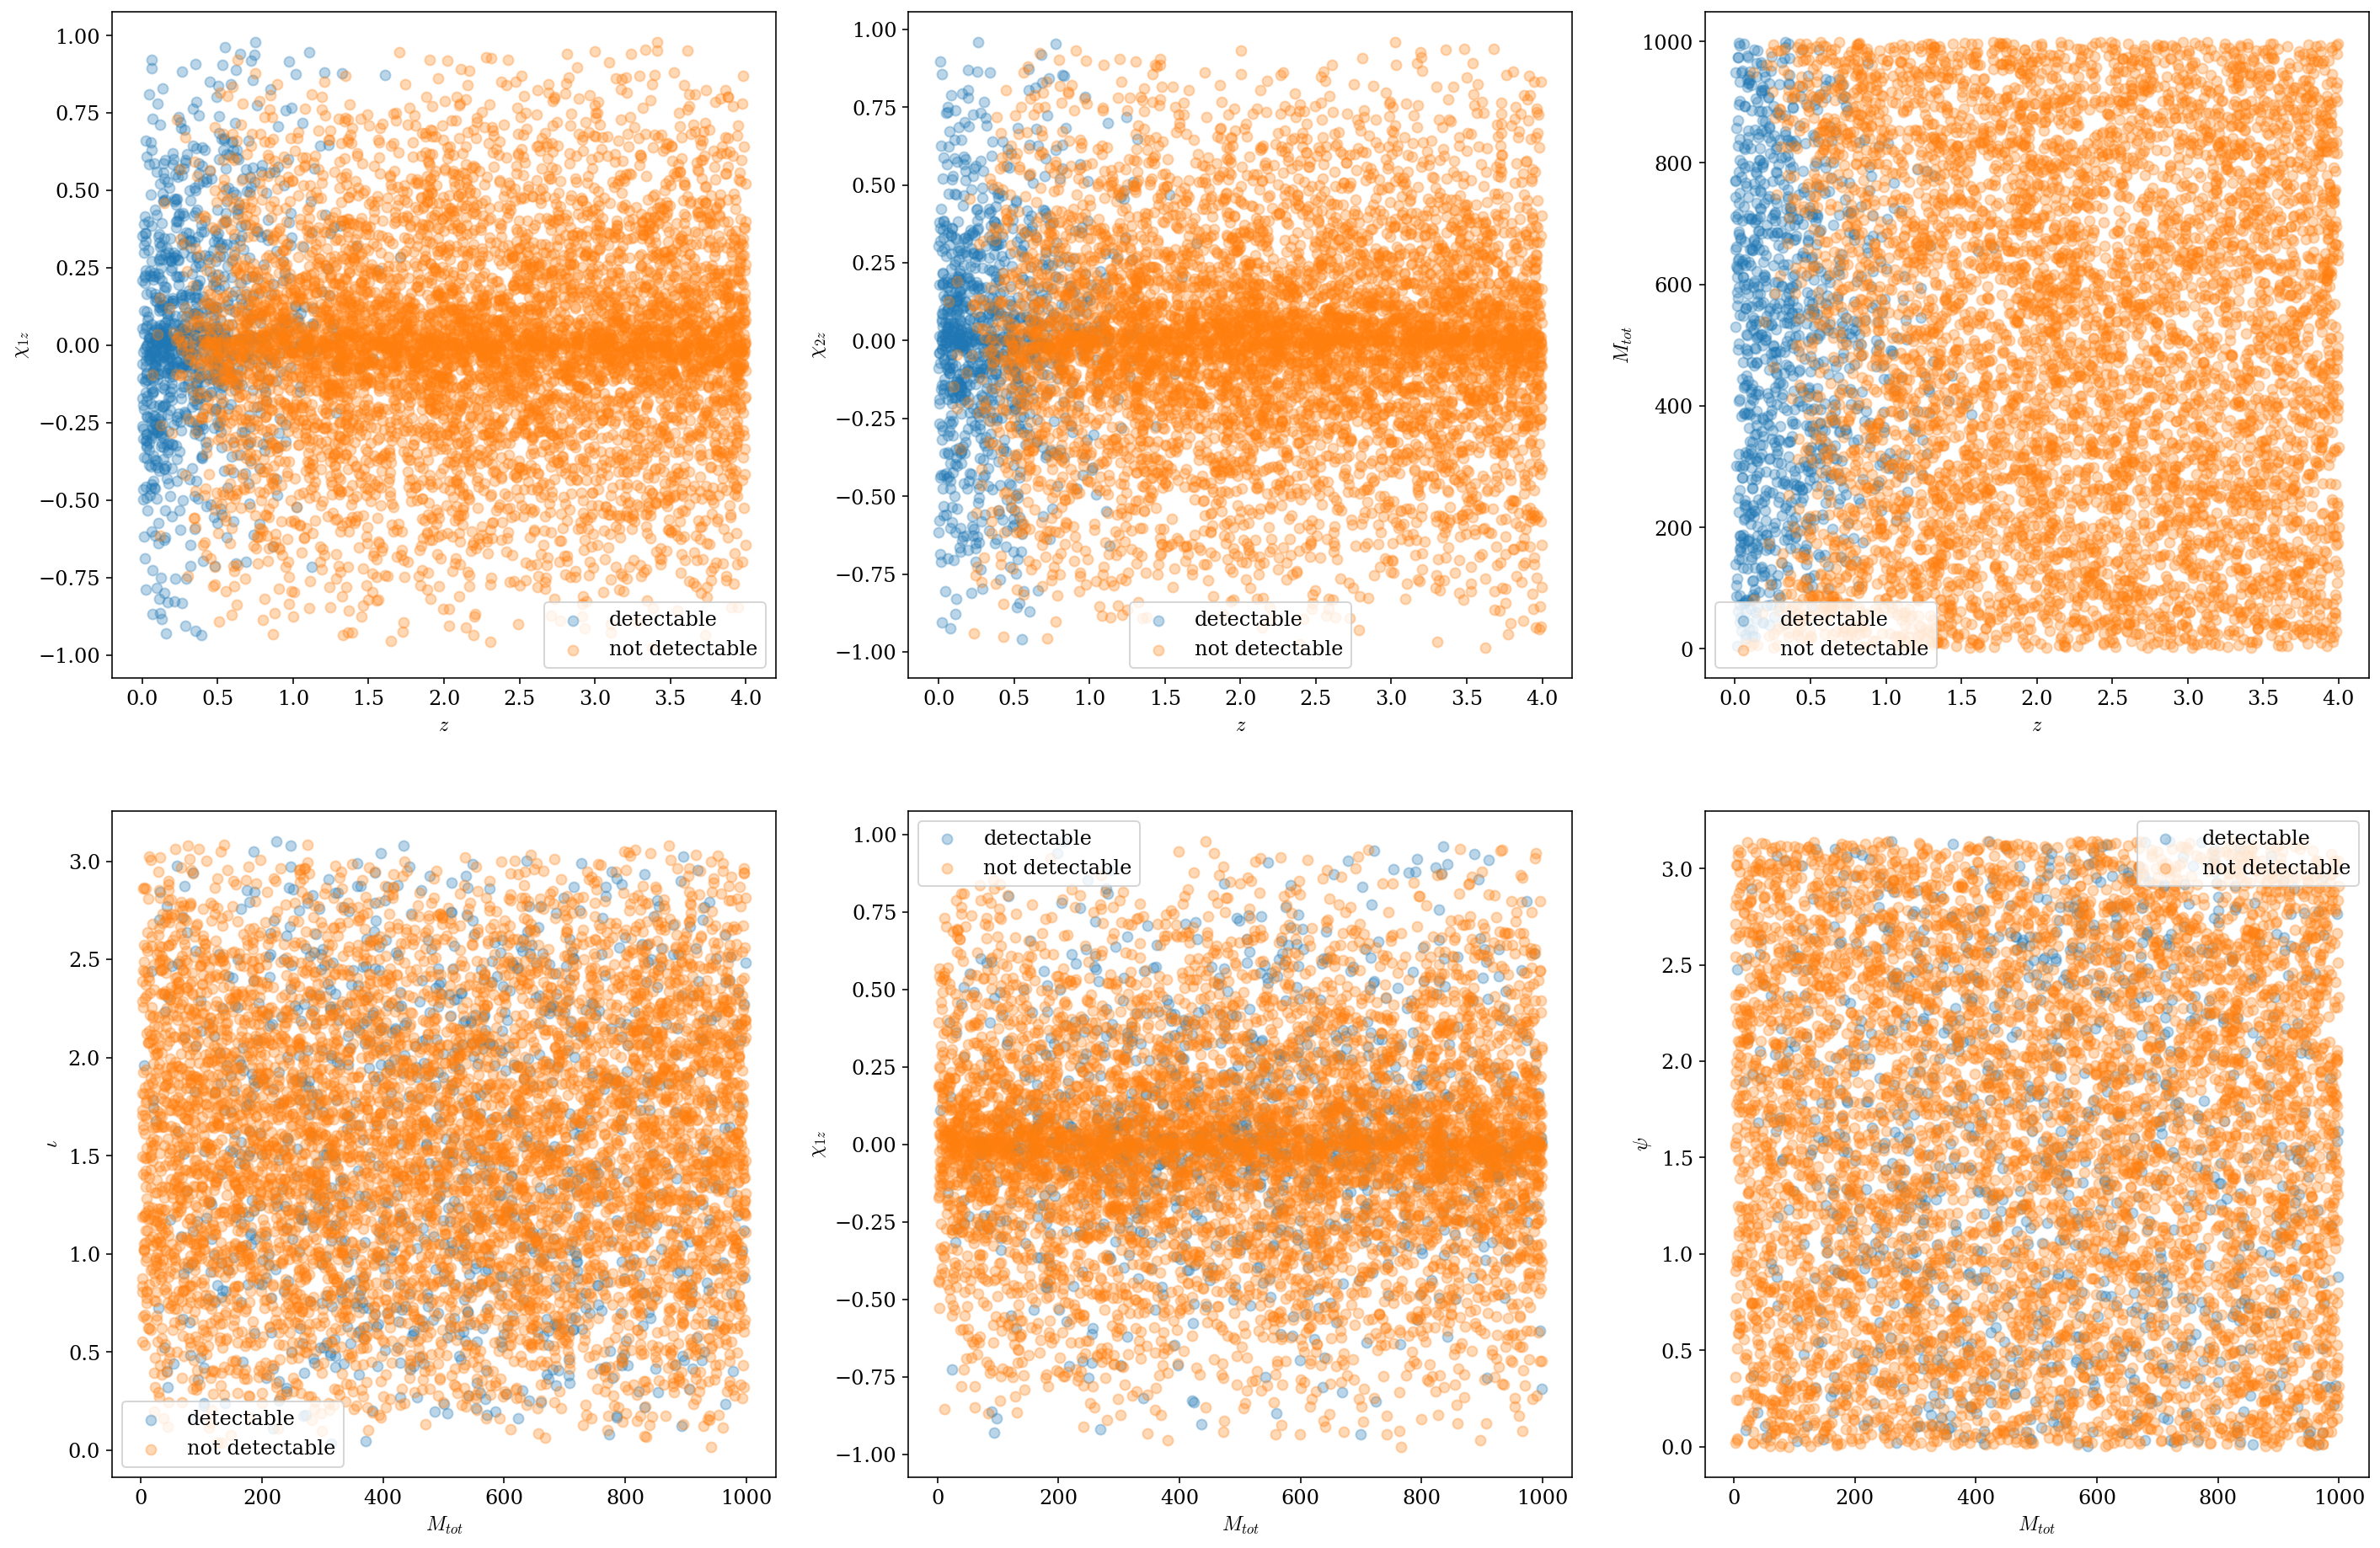

In [8]:
plt.figure(figsize=(24,16))

ax = plt.subplot(231)
ax.scatter(z_train[det_train == 1], chi1z_train[det_train == 1], alpha = 0.3, label = 'detectable')
ax.scatter(z_train[det_train == 0], chi1z_train[det_train == 0], alpha = 0.3, label = 'not detectable')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\chi_{1z}$')
ax.legend()

ax = plt.subplot(232)
ax.scatter(z_train[det_train == 1], chi2z_train[det_train == 1], alpha = 0.3, label = 'detectable')
ax.scatter(z_train[det_train == 0], chi2z_train[det_train == 0], alpha = 0.3, label = 'not detectable')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\chi_{2z}$')
ax.legend()

ax = plt.subplot(233)
ax.scatter(z_train[det_train == 1], mtot_train[det_train == 1], alpha = 0.3, label = 'detectable')
ax.scatter(z_train[det_train == 0], mtot_train[det_train == 0], alpha = 0.3, label = 'not detectable')
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$M_{tot}$')
ax.legend()

ax = plt.subplot(234)
ax.scatter(mtot_train[det_train == 1], iota_train[det_train == 1], alpha = 0.3, label = 'detectable')
ax.scatter(mtot_train[det_train == 0], iota_train[det_train == 0], alpha = 0.3, label = 'not detectable')
ax.set_xlabel(r'$M_{tot}$')
ax.set_ylabel(r'$\iota$')
ax.legend()

ax = plt.subplot(235)
ax.scatter(mtot_train[det_train == 1], chi1z_train[det_train == 1], alpha = 0.3, label = 'detectable')
ax.scatter(mtot_train[det_train == 0], chi1z_train[det_train == 0], alpha = 0.3, label = 'not detectable')
ax.set_xlabel(r'$M_{tot}$')
ax.set_ylabel(r'$\chi_{1z}$')
ax.legend()

ax = plt.subplot(236)
ax.scatter(mtot_train[det_train == 1], psi_train[det_train == 1], alpha = 0.3, label = 'detectable')
ax.scatter(mtot_train[det_train == 0], psi_train[det_train == 0], alpha = 0.3, label = 'not detectable')
ax.set_xlabel(r'$M_{tot}$')
ax.set_ylabel(r'$\psi$')
ax.legend()

plt.show()

### gaussian naive biases

In [28]:
classifiers, det_pred, det_proba = [], [], []
N_features = data_train.shape[1]
gamma, C = 0.1, 0.1
for n in range(1, N_features+1):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(data_train[:,0:n])
    X_test = scaler.fit_transform(data_test[:,0:n])
    
    clf = GaussianNB()

    clf.fit(X_train, det_train)
    classifiers.append(clf)

    det_pred.append(clf.predict(X_test))
    det_proba.append(clf.predict_proba(X_test)[:,1])

In [29]:
# Compute the decision boundary
clf = classifiers[1] #z - M_tot

xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

#xlim = (min(data_train[:,0]), max(data_train[:,0]))
#ylim = (min(data_train[:,1]), max(data_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 810),
                     np.linspace(ylim[0], ylim[1], 710))

#Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

In [30]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in det_proba:
    fpr, tpr, thresh = roc_curve(det_test, proba)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    thresh_list.append(thresh)

In [31]:
#contamination and completeness
completeness, contamination = completeness_contamination(det_pred, det_test)
print('completeness: ', completeness)
print('contamination: ', contamination)

completeness:  [0.82926829 0.84257206 0.84035477 0.84257206 0.84700665 0.85587583
 0.85587583]
contamination:  [0.29699248 0.28436911 0.27946768 0.26782274 0.26819923 0.25338491
 0.25769231]


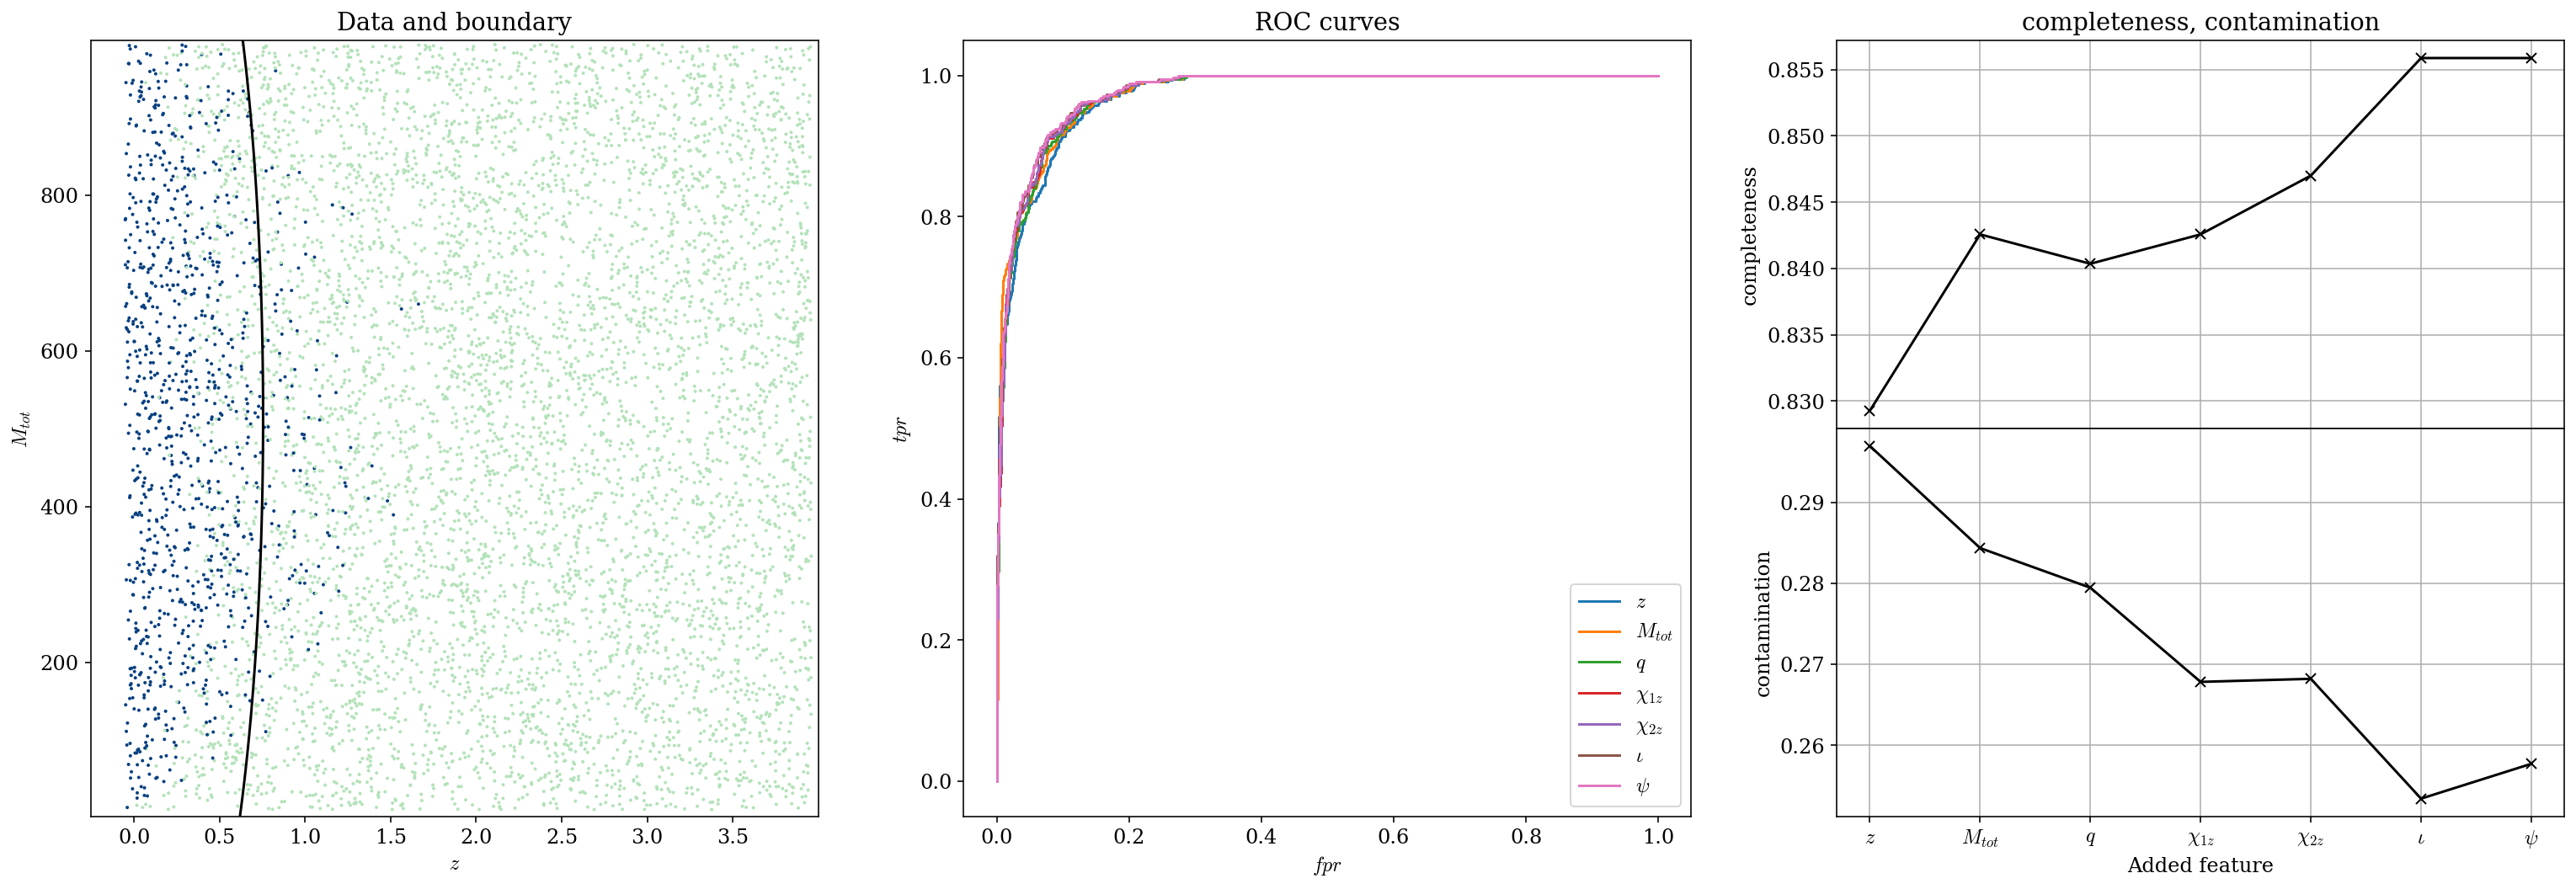

In [32]:
fig = plt.figure(figsize=(24, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)
ax1 = plt.subplot(131) #data: z vs chi_1z
ax2 = plt.subplot(132) #roc curves
ax3 = plt.subplot(233) #completeness
ax4 = plt.subplot(236) #contamination
#------------------------------------------------------------
im = ax1.scatter(scaler.inverse_transform(X_train)[:, 0], scaler.inverse_transform(X_train)[:, 1], c=det_train,
                s=4, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)

xlim = (min(data_train[:,0]), max(data_train[:,0]))
ylim = (min(data_train[:,1]), max(data_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 810),
                     np.linspace(ylim[0], ylim[1], 710))
ax1.contour(xx, yy, Z, [0.5], colors='k')
#ax1.contour(scaler.inverse_transform(xx), scaler.inverse_transform(yy), scaler.inverse_transform(Z), [0.5], colors='k')

#ax1.set_xlim(xlim)
#ax1.set_ylim(ylim)

ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$M_{tot}$')
ax1.set_title('Data and boundary')
#------------------------------------------------------------
for fpr, tpr, label in zip(fpr_list, tpr_list, labels):
    ax2.plot(fpr, tpr, label = label)
    ax2.legend()
    
ax2.set_xlabel(r'$fpr$')
ax2.set_ylabel(r'$tpr$')
ax2.set_title('ROC curves')
#------------------------------------------------------------
ax3.plot(range(1,N_features+1), completeness, 'x-k')
ax3.set_ylabel('completeness')
ax3.xaxis.set_major_formatter(plt.NullFormatter())
ax3.set_title('completeness, contamination')
ax3.set_xticks(range(1,8), labels)
ax3.grid(True)
#------------------------------------------------------------
ax4.plot(range(1,N_features+1), contamination, 'x-k')
ax4.set_xlabel('Added feature')
ax4.set_ylabel('contamination')
ax4.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax4.set_xticks(range(1,8), labels)
ax4.grid(True)
#------------------------------------------------------------
plt.show()

### Random forest

In [14]:
#cv on a single tree to find the best depth
clf = DecisionTreeRegressor()
d_range = np.arange(1,15)
d_best = []
for n in range(1, N_features+1):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(data_train[:,0:n])
    X_test = scaler.fit_transform(data_test[:,0:n])
    
    grid = GridSearchCV(clf, param_grid={'max_depth': d_range}, cv=5) 
    grid.fit(X_train, det_train)

    best = grid.best_params_['max_depth']
    d_best.append(best)
    print("best parameter choice:", best)

best parameter choice: 3
best parameter choice: 5
best parameter choice: 5
best parameter choice: 5
best parameter choice: 5
best parameter choice: 7
best parameter choice: 5
